# Импорт библиотек и данных

Launch a server via:
```bash
mlflow server --host 127.0.0.1 --port 8080
```

In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.models import infer_signature

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate,\
    GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

root_folder = '../'
sys.path.append(root_folder)

from src.visualization import visualize
from src.models import train_model
from src.utils import get_dict

baseline_data = Path(root_folder, 'data', 'processed', '1.0_baseline.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 374306 entries, 0 to 374305
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   baths         267467 non-null  float64
 1   fireplace     374306 non-null  bool   
 2   sqft          333384 non-null  float64
 3   beds          277504 non-null  float64
 4   stories       221109 non-null  float64
 5   target        374306 non-null  int64  
 6   private_pool  374306 non-null  bool   
 7   mls           374306 non-null  bool   
 8   year_built    311041 non-null  float64
 9   lotsize       279341 non-null  float64
dtypes: bool(3), float64(6), int64(1)
memory usage: 23.9 MB


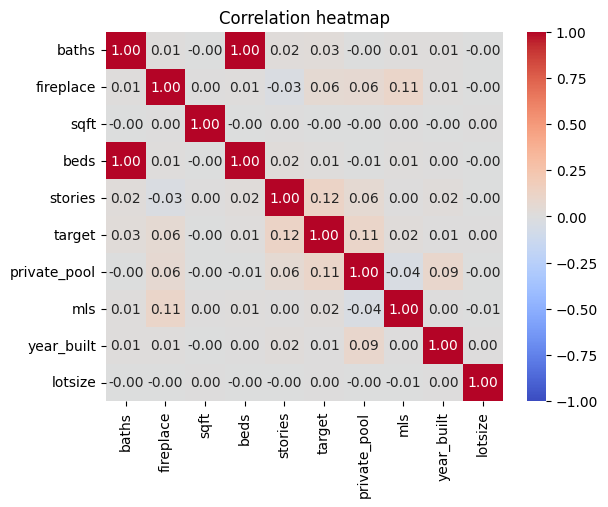

In [2]:
df = pd.read_csv(
    baseline_data,
    index_col=0
)
df.info()
df.describe()

visualize.plot_heatmap(
    df.corr(),
    title='Correlation heatmap',
);

Видим сильную корреляцию количества спален и ванный комнат, что нужно иметь ввиду.

Также исключим стоимости за пределами большинства предложений

In [3]:
df = df.drop('baths', axis=1)
df_crop = df[df['target'].between(1e5, 1e6)]
df = df_crop

# Prepare data
X, y = train_model.get_X_y(df)

X shape: (285081, 8)
y shape: (285081,)


Проводим обучение и оценку метрик в кросс-валидации

In [4]:
# random_state = 42

# Prepare pipe
imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)
pipe_elements = [
    ('imputer', SimpleImputer, imputer_params),
    ('scaler', MinMaxScaler),
    ('regressor', LinearRegression)
]
pipe, pipe_params = train_model.make_pipeline(pipe_elements)
display(pipe)

# Conduct fitting and cross-validation metrics estimation
metrics = train_model.cross_validate_pipe(
    pipe=pipe,
    X=X,
    y=y,
)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()), ('regressor', LinearRegression())])

,train,test
mape,0.572,0.573
r2,0.025,-0.296


Получили неудовлетворительные показатели на тесте по r2 (как и на train).

Но всё равно сохраним как самую первую, пробную модель

In [5]:
pipe.fit(X, y)
print('WARNING: fit on all data')

model_info = train_model.log_pipe_mlflow(
    pipe_name='baseline-linreg',
    training_info='Linear regression baseline',
    X=X,
    pipe=pipe,
    pipe_params=pipe_params,
    metrics=metrics,
)

Registered model 'baseline-linreg' already exists. Creating a new version of this model...
2024/04/20 01:26:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: baseline-linreg, version 2
Created version '2' of model 'baseline-linreg'.


Посмотрим на поведение дерева решений на этом же датасете, 
предваритально подобрав оптимальную максимальную глубину (по r2)

In [8]:
# Prepare pipe
imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)
dtree_params = get_dict(
    # max_depth=20,
    random_state=42
)
pipe_elements = [
    ('imputer', SimpleImputer, imputer_params),
    ('scaler', MinMaxScaler),
    ('regressor', DecisionTreeRegressor, dtree_params)
]
pipe, pipe_params = train_model.make_pipeline(pipe_elements)
display(pipe)

max_depth_grid = [2, 4, 8, 10, 12, 16, 20, 24, 28, 32, 64, 128]
grid = GridSearchCV(
    pipe,
    param_grid={
        'regressor__max_depth': max_depth_grid,
    },
    scoring=(
        'neg_mean_absolute_error',
        'r2'
    ),
    refit='r2',
    n_jobs=-1,
    return_train_score=True,
)
grid.fit(X, y)
# print(f'Best mean absolute error: {-grid.best_score_:.3e}')
print(f'Best r2-score: {grid.best_score_:.3f}')
print(f'Best params:', grid.best_params_)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('regressor', DecisionTreeRegressor(random_state=42))])

Best r2-score: 0.204
Best params: {'regressor__max_depth': 12}


In [9]:
# random_state = 42

# Prepare pipe
imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)
dtree_params = get_dict(
    max_depth=12,
    random_state=42
)
pipe_elements = [
    ('imputer', SimpleImputer, imputer_params),
    ('scaler', MinMaxScaler),
    ('regressor', DecisionTreeRegressor, dtree_params)
]
pipe, pipe_params = train_model.make_pipeline(pipe_elements)
display(pipe)

# Conduct fitting and cross-validation metrics estimation
metrics = train_model.cross_validate_pipe(
    pipe=pipe,
    X=X,
    y=y,
)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('regressor',
                 DecisionTreeRegressor(max_depth=12, random_state=42))])

,train,test
mape,0.470,0.484
r2,0.257,0.204


Логируем дерево решений

In [10]:
pipe.fit(X, y)
print('WARNING: fit on all data')

model_info = train_model.log_pipe_mlflow(
    pipe_name='baseline-dtree',
    training_info='Decision tree baseline',
    X=X,
    pipe=pipe,
    pipe_params=pipe_params,
    metrics=metrics,
)

/home/vulf/.cache/pypoetry/virtualenvs/housing-cost-EeioB1ZZ-py3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/vulf/.cache/pypoetry/virtualenvs/housing-cost-EeioB1ZZ-py3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'baseline-dtree' already exists. Creating a new version of this model...
2024/04/20 01:29:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation.

## Выводы по бейзлайнам

Таким образом, по обоим метрикам лучше всего себя показывает дерево решений с оптимизированной глубиной.

Следующие модели будем сравнивать с показателями:
- **MAPE**: $0.48$ (то есть ошибка $48\%$)
- **R^2**: $0.20$